# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [3]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob

train_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/train/*.jpg"
test_w_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/test_w/*.jpg"
test_m_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/test_m/*.jpg"
train_images = {}
test_w_images = {}
test_m_images = {}

n_train = len(glob.glob(train_path))
n_test_m = len(glob.glob(test_m_path))
n_test_w = len(glob.glob(test_m_path))


valid_data = []
test_m_data = []
test_w_data = []


def clean_data(path):
  n = len(glob.glob(path))
  arr = np.zeros((n//6, 3, 2, 224,224,3))

  names = set()

  for file in glob.glob( path):
    name = file.split("/")[-1]     # get the name of the .jpg file
    name = name.split("_") # now it looks like ["u038", "3", "left", "m" ]
    names.add(name[0])

  names = list(names)
  for file in glob.glob(path):


    name = file.split("/")[-1]          # get the name of the .jpg file
    name = name.split("_")              # now it looks like ["u038", "3", "left", "m" ]

    img = plt.imread(file)               # read the image as a numpy array
    img = img/255 - 0.5                  # normalizing
    img  = img[:, :, :3]              # remove the alpha channel

    id =names.index(name[0])
    pair_num = int(name[1]) -1          
    side = 0 if name[2] == "left" else 1
    arr[id,pair_num,side] = img
    #print(f'id:{id}\nside:{side}\pair:{pair_num}\n{arr[id,pair_num,side]}')
  return arr

train_data = clean_data(train_path)
n = int(len(train_data)*0.8)
train_data, valid_data = train_data[:n], train_data[n:]
test_m_data = clean_data(test_m_path)
test_w_data = clean_data(test_w_path)



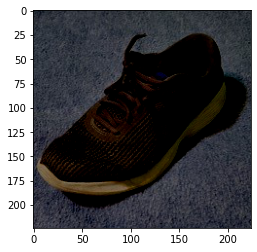

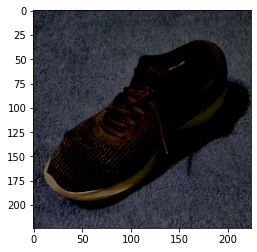

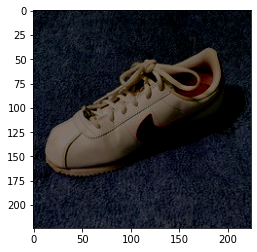

In [4]:
# Run this code, include the image in your PDF submission
plt.figure()
im =  train_data[4,0,0,:,:,:]
plt.imshow(im) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


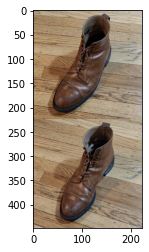

In [5]:
from matplotlib import figure
# Your code goes here
def generate_same_pair(arr):
  res = np.zeros((len(arr)*3,448,224,3))

  # fill the blank tensor

  for i, im in enumerate(arr):
    for j in range (3):
      
      n= 3*i+j

      res[n] = np.vstack((arr[i,j,0],arr[i,j,1]))
      #res[n, :224] =  arr[i,j,0]
      #res[n, 224:,:,:] =  arr[i,j,1]


  return res

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]

plt.figure()
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)
(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


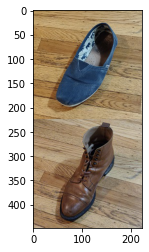

In [6]:
# Your code goes here
from matplotlib import figure
# Your code goes here
def generate_different_pair(arr):
  res = np.zeros((len(arr)*3,448,224,3))

  # fill the blank tensor

  for i, im in enumerate(arr):
    for j in range (3):
      s = np.random.choice([1,2])
      n= 3*i+j

      res[n] = np.vstack((arr[i,(j+s)%3,0],arr[i,j,1]))
      #res[n, :224] =  arr[i,j,0]
      #res[n, 224:,:,:] =  arr[i,j,1]


  return res

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]

plt.figure()
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:** PLEASE COMPLETE :❤❤❤❤❤❤❤❤❤❤❤❤

each person was requested to picture the shoes with the same background. In order to specify the differences between the pictures into the difference between the shoes only, we would need the background to be the same. having different shoes and background would make it harder for the model to decide whether the shoes is the source to the difference or the background.



### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**


Not having a balanced data may lead to a bias towards classifying all the data to the primary kind of data. for example, having 99% of the images of shoes that are not from the same pair and only 1% of the same pair may lead to classifying all the shoes for 'not the same pair'. in this case it would even present a 99% accurcy which is definately not representing a useful model.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [42]:
class CNN(nn.Module):
    def __init__(self, n=4):

        super(CNN, self).__init__()
        # TODO: complete this method
        s = 1
        k = 5
        self.n =n 
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(3,n,k,s,(k-1)//2)

        self.conv2 = nn.Conv2d(n,2*n,k,s,(k-1)//2)

        self.conv3 = nn.Conv2d(2*n,4*n,k,s,(k-1)//2)

        self.conv4 = nn.Conv2d(4*n,8*n,k,s,(k-1)//2)

        self.layer5 = nn.Linear(8*14*14*2*n,100)
        self.layer6 = nn.Linear(100,2)

    def forward(self,x,verbose=False):
        x = F.max_pool2d(F.relu(self.conv1(x)),2,2)

        x = F.max_pool2d(F.relu(self.conv2(x)),2,2)

        x = F.max_pool2d(F.relu(self.conv3(x)),2,2)

        x = F.max_pool2d(F.relu(self.conv4(x)),2,2)


        x = torch.flatten(x,1)

        x = F.relu(self.layer5(x)) 
        x = self.layer6(x)


        return x


    # TODO: complete this class

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [46]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()

        s = 1
        k = 5
        self.n =n 
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=5, stride=1, padding=(k-1)//2, bias=True)

        self.conv2 = nn.Conv2d(n,2*n,k,s,(k-1)//2)

        self.conv3 = nn.Conv2d(2*n,4*n,k,s,(k-1)//2)

        self.conv4 = nn.Conv2d(4*n,8*n,k,s,(k-1)//2)

        self.layer5 = nn.Linear(8*14*14*n,100)
        self.layer6 = nn.Linear(100,2)


        
    def forward(self, x, verbose=False):

        
        x = torch.cat((x[:,:,224:,:], x[:,:,:224,:]), 1) # put 2 sides on top of each other, batch size stay the same
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2,2)
        x = F.max_pool2d(F.relu(self.conv3(x)),2,2)
        x = F.max_pool2d(F.relu(self.conv4(x)),2,2)

        x = torch.flatten(x,1)
        x = F.relu(self.layer5(x)) 
        x = self.layer6(x)
        return x


In [9]:
train_data_t = (torch.tensor(train_data))
print(len(train_data_t))
valid_data_t = (torch.tensor(valid_data))

89


## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

Using the 'CNN Channel' architecture is better because it makes the feature construction on both images at the same time, where the channels are one on top of the other. This configuration makes use of the CNN advantages while relating both images, of the left and right shoes, instead of making the weights of both images seperately.



## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

Tracking the accuracy for both positive and negative samples may be helpful to track some issues about the model behavior, and track it down. Having different preformance on validation with different types of data data may be caused by a biased model, and seek for a balanced data configuration.

in general, if it is for some reason more importand to make an accuracy for some type of data recognition, than it is useful to track its accuracy seperately and improve the model correspondingly.




In [10]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        xs = xs.transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs = xs.transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [48]:

def nn_train(model,
              train_data,
              validation_data=valid_data_t,
              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=None):
#main training loop; choice of loss function; choice of optimizer
  #print("hi")
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
  
  iters, losses = [], []
  iters_sub, train_accs_pos , train_accs_neg, val_accs_pos, val_accs_neg  = [], [] ,[],[],[]
  #print("hi2")

  n = -1 # the number of iterations
  while n < max_iters:
      for i in range(0, len(train_data), batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            #print("here")    

            #obtaining the positive and negative samples
            pos_xt = generate_same_pair(train_data[np.random.choice(train_data.shape[0],batch_size,replace=False)])
            neg_xt =generate_different_pair(train_data[np.random.choice(train_data.shape[0],batch_size,replace=False)])
           
            #shuffling the positive and negative samples at the start of each epoch
            #print("hi3")
 
            len1=len(pos_xt)    #3*n images

            #in each iteration, take batch_size / 2 positive samples and batch_size / 2 negative samples as our input for this batch
            #pos_st,neg_st = np.ones(batch_size / 2), np.zeros(batch_size / 2)

            xt=torch.zeros((len1,448,224,3))
            pos_st,neg_st = np.ones((len1 // 2)), np.zeros((len1 // 2))
            st = np.concatenate((pos_st,neg_st),axis=0)
            st = np.random.permutation(st)
            st_or = np.zeros((len1,2))
            
            dict_xt= {0:torch.Tensor(neg_xt), 1: torch.Tensor(pos_xt)}
            #in each iteration, take np.ones(batch_size / 2) as the labels for the positive samples, and np.zeros(batch_size / 2) as the labels for the negative samples
            
            #print(xt.shape)
            for j in range(len1):
              xt[j]=dict_xt[st[j]][j]
              if st[j]:
                st_or[j,1]=1
              else:
                  st_or[j,0]=1

           
            
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            #pos_st, neg_st = torch.tensor(pos_st), torch.tensor(neg_st) 
            
            train=xt
            xt=xt.transpose(1,3)
            xt = xt.transpose(2, 3)
            st=torch.tensor(st_or)
            
            zs = model(xt)
            
            #print('zs=', zs.shape, zs)  
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            #print("got optimized")

            #after every epoch, report the accuracies for the training set and validation set
            if n % 100==0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc_pos,train_acc_neg  = get_accuracy(model, train_data,batch_size)
                train_accs_pos.append(train_acc_pos)
                train_accs_neg.append(train_acc_neg)
                val_acc_pos , val_acc_neg = get_accuracy(model, validation_data,batch_size)
                val_accs_pos.append(val_acc_pos)
                val_accs_neg.append(val_acc_neg)
                print("Iter %d. [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train pos Acc %.0f%%,Train neg Acc %.0f%%, Loss %f]" % (n, val_acc_pos * 100,val_acc_neg * 100, train_acc_pos * 100, train_acc_neg * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg
        
            
            


          #track the training curve information and plot the training curve
        
              
  return losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg

            

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [12]:
# Write your code here. Remember to include your results so that we can

CNN_5_Channel = CNNChannel()
history_5_Channel = nn_train(CNN_5_Channel,train_data_t[0:5],valid_data_t[0:5],2,learning_rate=0.0005,
              weight_decay=0,
              max_iters=500,
              checkpoint_path=None)

# see that your model attains a high training accuracy. 

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.692964]
Iter 100. [Val pos Acc 87%] [Val neg Acc 73%] [Train pos Acc 100%,Train neg Acc 60%, Loss 0.123200]
Iter 200. [Val pos Acc 87%] [Val neg Acc 80%] [Train pos Acc 100%,Train neg Acc 93%, Loss 0.001146]
Iter 300. [Val pos Acc 73%] [Val neg Acc 87%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.003277]
Iter 400. [Val pos Acc 67%] [Val neg Acc 80%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.000183]
Iter 500. [Val pos Acc 67%] [Val neg Acc 87%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.000239]


In [21]:
# Write your code here. Remember to include your results so that we can

CNN_5 = CNN()
history_5 = nn_train(CNN_5,train_data_t[0:5],valid_data_t[0:5],4,learning_rate=0.0005,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=None)

# see that your model attains a high training accuracy. 

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.696062]
Iter 100. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 20%,Train neg Acc 93%, Loss 0.692306]
Iter 200. [Val pos Acc 93%] [Val neg Acc 7%] [Train pos Acc 60%,Train neg Acc 47%, Loss 0.694935]
Iter 300. [Val pos Acc 20%] [Val neg Acc 93%] [Train pos Acc 53%,Train neg Acc 53%, Loss 0.697159]
Iter 400. [Val pos Acc 73%] [Val neg Acc 40%] [Train pos Acc 87%,Train neg Acc 87%, Loss 0.591040]
Iter 500. [Val pos Acc 80%] [Val neg Acc 27%] [Train pos Acc 87%,Train neg Acc 100%, Loss 0.034002]
Iter 600. [Val pos Acc 67%] [Val neg Acc 53%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.025291]
Iter 700. [Val pos Acc 80%] [Val neg Acc 40%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.001542]
Iter 800. [Val pos Acc 80%] [Val neg Acc 47%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.000752]
Iter 900. [Val pos Acc 80%] [Val neg Acc 47%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.000137]


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

learning rate - first, we tried learning rate of 0.001 and we saw that we had big "steps" of the validation accuracy so we decided to decrese the learning rate.

batch- we tried different batch sizes, a bigger batch size led to lesser results with bigger run time, then we tried  batch size of 10 that improved our accuracy.

our model seemed to always overfit, one thing that helped prevent that was adding the weight decay of 5e-5, weight dacay decrese the model's probabilty to memorizing the training data.

In [30]:
# Include the training curves for the two models.

CNN_Channel = CNNChannel()
history_channel = nn_train(CNN_Channel,train_data_t,valid_data_t,10,learning_rate=0.0001,
              weight_decay=5e-5,
              max_iters=1000,
              checkpoint_path=f'/content/gdrive/My Drive/Intro_to_Deep_Learning/data/CNN_CHANNEL')


Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.694552]
Iter 100. [Val pos Acc 35%] [Val neg Acc 87%] [Train pos Acc 46%,Train neg Acc 76%, Loss 0.680388]
Iter 200. [Val pos Acc 81%] [Val neg Acc 83%] [Train pos Acc 91%,Train neg Acc 74%, Loss 0.371747]
Iter 300. [Val pos Acc 78%] [Val neg Acc 96%] [Train pos Acc 90%,Train neg Acc 83%, Loss 0.366972]
Iter 400. [Val pos Acc 78%] [Val neg Acc 87%] [Train pos Acc 87%,Train neg Acc 88%, Loss 0.269074]
Iter 500. [Val pos Acc 81%] [Val neg Acc 87%] [Train pos Acc 91%,Train neg Acc 91%, Loss 0.402457]
Iter 600. [Val pos Acc 84%] [Val neg Acc 87%] [Train pos Acc 94%,Train neg Acc 79%, Loss 0.329268]
Iter 700. [Val pos Acc 77%] [Val neg Acc 90%] [Train pos Acc 89%,Train neg Acc 93%, Loss 0.224803]
Iter 800. [Val pos Acc 78%] [Val neg Acc 91%] [Train pos Acc 92%,Train neg Acc 92%, Loss 0.250384]
Iter 900. [Val pos Acc 81%] [Val neg Acc 93%] [Train pos Acc 92%,Train neg Acc 91%, Loss 0.088765]
Iter 1000. [

In [43]:
CNN = CNN()
history = nn_train(CNN,train_data_t,valid_data_t,10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path='/content/gdrive/My Drive/Intro_to_Deep_Learning/data/CNN')

# see that your model attains a high training accuracy. 

Iter 0. [Val pos Acc 94%] [Val neg Acc 12%] [Train pos Acc 82%,Train neg Acc 14%, Loss 0.693344]
Iter 100. [Val pos Acc 99%] [Val neg Acc 0%] [Train pos Acc 99%,Train neg Acc 1%, Loss 0.693444]
Iter 200. [Val pos Acc 46%] [Val neg Acc 51%] [Train pos Acc 36%,Train neg Acc 65%, Loss 0.694900]
Iter 300. [Val pos Acc 72%] [Val neg Acc 20%] [Train pos Acc 63%,Train neg Acc 36%, Loss 0.690772]
Iter 400. [Val pos Acc 49%] [Val neg Acc 51%] [Train pos Acc 40%,Train neg Acc 65%, Loss 0.690831]
Iter 500. [Val pos Acc 25%] [Val neg Acc 81%] [Train pos Acc 20%,Train neg Acc 85%, Loss 0.683669]
Iter 600. [Val pos Acc 77%] [Val neg Acc 29%] [Train pos Acc 76%,Train neg Acc 35%, Loss 0.715334]
Iter 700. [Val pos Acc 59%] [Val neg Acc 54%] [Train pos Acc 57%,Train neg Acc 54%, Loss 0.707160]
Iter 800. [Val pos Acc 61%] [Val neg Acc 57%] [Train pos Acc 56%,Train neg Acc 48%, Loss 0.693401]
Iter 900. [Val pos Acc 64%] [Val neg Acc 54%] [Train pos Acc 63%,Train neg Acc 46%, Loss 0.653051]
Iter 1000. [Va

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

Text(0.5, 1.0, 'val_acc_neg')

<Figure size 432x288 with 0 Axes>

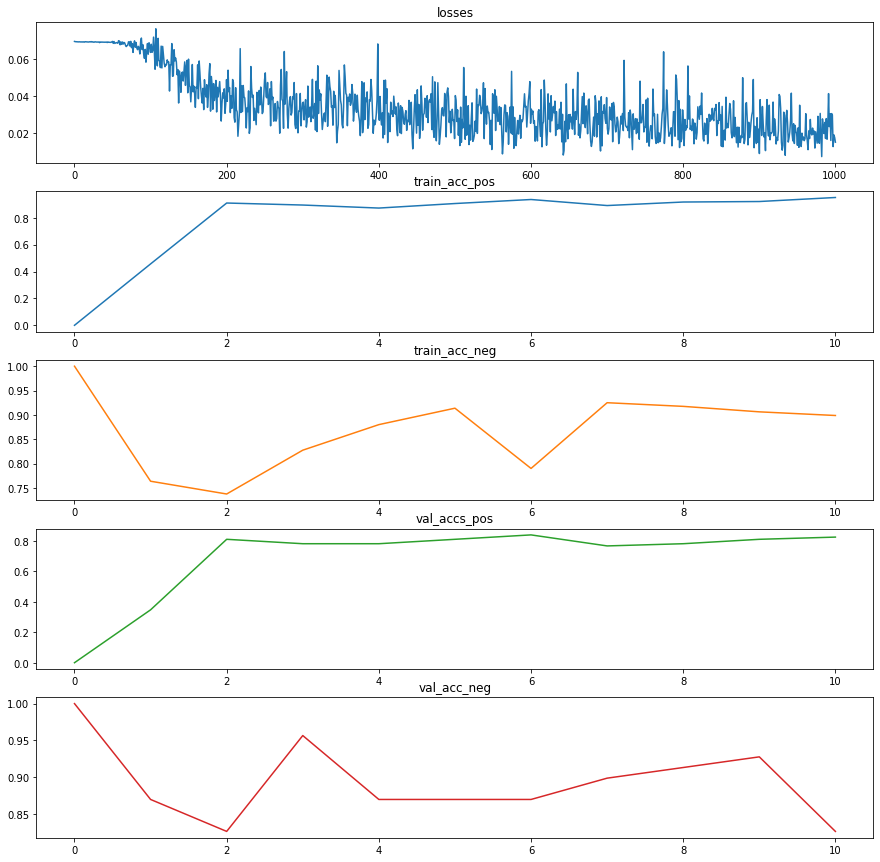

In [44]:
from numpy.core.function_base import linspace
plt.figure()
losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg = history_channel

N = range(len(losses))

fig, axs = plt.subplots(5,figsize=(15, 15))

axs[0].plot(N, losses)
axs[0].set_title('losses')

N = range(len(train_accs_pos))
axs[1].plot(N, train_accs_pos)
axs[1].set_title('train_acc_pos')
axs[2].plot(N,train_accs_neg , 'tab:orange')
axs[2].set_title('train_acc_neg')
axs[3].plot(N, val_accs_pos, 'tab:green')
axs[3].set_title('val_accs_pos')
axs[4].plot(N, val_accs_neg, 'tab:red')
axs[4].set_title('val_acc_neg')

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [51]:
#generate matching pairs, test our model on them
best_model=CNNChannel()
best_model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/data/CNN_CHANNEL900'))

same_m = generate_same_pair(test_m_data)
same_m = torch.FloatTensor(same_m).transpose(1,3).transpose(2, 3)

same_w = generate_same_pair(test_w_data)
same_w = torch.FloatTensor(same_w).transpose(1,3).transpose(2, 3)

#
pred_m = best_model(torch.FloatTensor(same_m))
pred_m = np.argmax(pred_m.detach().numpy(), axis=1)
accuracy_m = np.sum(pred_m)/len(pred_m)

pred_w = best_model(torch.FloatTensor(same_w))
pred_w = np.argmax(pred_w.detach().numpy(), axis=1)
accuracy_w = np.sum(pred_w)/len(pred_w)

print(f'prediction accuracy for women test data is:{accuracy_w}\nprediction accuracy for men test data is:{accuracy_m}')


prediction accuracy for women test data is:0.8
prediction accuracy for men test data is:0.8


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.



If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

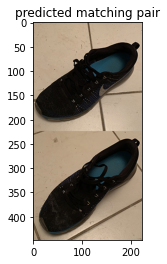

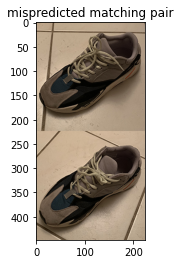

In [52]:

for i, p in enumerate(pred_m):
  if p:
    plt.figure()
    plt.imshow(generate_same_pair(test_m_data)[i]+0.5) 
    plt.title("predicted matching pair")
    break

for i, p in enumerate(pred_m):
  if not p:
    plt.figure()
    plt.imshow(generate_same_pair(test_m_data)[i]+0.5) 
    plt.title("mispredicted matching pair")
    break




### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

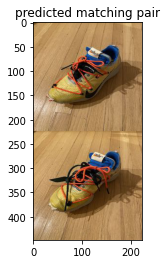

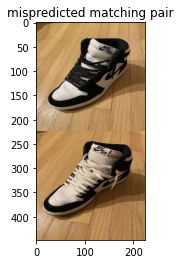

In [54]:

for i, p in enumerate(pred_w):
  if p:
    plt.figure()
    plt.imshow(generate_same_pair(test_w_data)[i]+0.5) 
    plt.title("predicted matching pair")
    break

for i, p in enumerate(pred_w):
  if not p:
    plt.figure()
    plt.imshow(generate_same_pair(test_w_data)[i]+0.5) 
    plt.title("mispredicted matching pair")
    break

